## Librairy imports and helper function

Importing python librairies used in this notebook ...

In [98]:
# Base python 3.9.12
import os.path as pth
import matplotlib.pyplot as plt # Matplotlib v3.5.1
import numpy as np # Numpy v1.23.4
import os
import json
import h5py
from typing import Union
import pandas as pd

import matplotlib as mpt
from cycler import cycler

mpt.rcParams['lines.linewidth'] = 1.4
mpt.rcParams['font.size'] = 12
mpt.rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b', 'y'])
plt.style.use('default')

def set_my_layout(ax: plt.Axes, xlabel: str, ylabel: str, title: str=None, legend_loc=(0.01,0.01), set_legend=True) -> plt.Axes:
    """Sets my personal layout used in all official figures

    Args:
        ax (plt.Axes): the pyplot axes
        xlabel (str): x-axis label
        ylabel (str): y-axis label
        title (str, optional): title of the figure. Defaults to None.
        legend_loc (tuple, optional): location of the legend box in 2D coordinates. Defaults to (0.01,0.01).
        withlegend (bool, optional): whether to put the legend box. Defaults to False.
        legends (_type_, optional): legends list. Defaults to None.

    Returns:
        plt.Axes: the pyplot axes (self return)
    """
    
    if title != None:
        ax.set_title(title, fontdict={'color': 'black', 'size': 14})
    ax.set_xlabel(xlabel, fontdict={'color': 'black', 'size': 14})
    ax.set_ylabel(ylabel, fontdict={'color': 'black', 'size': 14})
    ax.tick_params(axis='y', colors='black', labelsize=14)
    ax.tick_params(axis='x', colors='black', labelsize=14)
    if set_legend:
        ax.legend(prop={'size': 12}, loc=legend_loc)
    # ax.xaxis.major.formatter._useMathText = True
    return ax

def generate_reduced_network_node_id_dict(clustered_nodes: list[int]) -> dict:
    """Generates dictionary to identify the remaining nodes from the original network nodes

    Args:
        clustered_nodes (list[int]): list of clustered nodes (in julia indexing)

    Returns:
        dict: dictionary to associate the original node id to the reduced network node ids
    """
    step = 0
    dict_ = {}
    for i in range(71): # There is 71 nodes in the case study network 1
        if (i+1) in clustered_nodes:
            step += 1
        dict_[i] = i-step
    return dict_

## Reading and loading hybrid simualtion results

Reading the information on the aggregated clusters of the case study network 1: this json file contains the list of the clusters identified by alpha-numeric keys (e.g., "a", "b", "manual_1", ...), the substation nodes composing the clusters, the indices of the external pipes and the types of the clusters. In some tests, we combine two clusters identified by combinaison of identifier keys (e.g., "g_manual_1" reduces the network by aggregating the cluster "g" and the cluster "manual_1").

In [ ]:
# Read json files containing information about the clusters

with open('clusters_informations_for_hybrid_simulations.json') as json_file:
    clusters_infos =  json.load(json_file)

From the .mat files, we load the simulation results of full network physic-based simulation and the different reduced networks hybrid simulations, for the two control test scenarios presented in our paper. Note that we use the identifier of the cluster to identify the simulation results and "var" and "step" respectively for the two scenarios.

In [ ]:
# Simulation results are in the folder ARTICLE_hybrid_results

model_considered = 'rnn' # change to cnn if needed !! Note that some hybrid simulation results does not exist in cnn
simulation_result_folder = os.path.join('.', 'ARTICLE_hybrid_results')
considered_clusters_keys = ["a", "b", "c", "d", "e", "f", "g_manual_1", "f_manual_1", "m"]

# 1st scenario
first_scenario_results = {}
full_network_physical_file_path = os.path.join(simulation_result_folder, 'new_simulation_data_original_var_tss_dhn1.mat')
first_scenario_results['full_physic'] = h5py.File(full_network_physical_file_path, 'r') # Dict ['load', 'mc', 'mw', 'topology_load', 'tr', 'trcs', 'trin', 'trout', 'ts', 'tsin', 'tsout']
for cluster_key in considered_clusters_keys:
    reduced_file_path_rnn = os.path.join(simulation_result_folder, f'hybrid_cluster_{cluster_key}_var_tss_{model_considered}.mat')
    first_scenario_results[cluster_key] = h5py.File(reduced_file_path_rnn, 'r')
    
# 2nd scenario
second_scenario_results = {}
full_network_physical_file_path = os.path.join(simulation_result_folder, 'new_simulation_data_original_step_tss_dhn1.mat')
second_scenario_results['full_physic'] = h5py.File(full_network_physical_file_path, 'r')
for cluster_key in considered_clusters_keys:
    reduced_file_path_rnn = os.path.join(simulation_result_folder, f'hybrid_cluster_{cluster_key}_step_tss_{model_considered}.mat')
    second_scenario_results[cluster_key] = h5py.File(reduced_file_path_rnn, 'r')


# Some preprocessing of results
first_dynamic_step_interest = 1*60
last_dynamic_steps_horizon = 7*24*60 - 1 # 1 week only for minute-time steps
for key in first_scenario_results:
    dict_ = {}
    for physical_state_key in first_scenario_results[key]:
        array = np.array(first_scenario_results[key][physical_state_key])
        if physical_state_key in ['trcs', 'mc']: # We take all for those
            dict_[physical_state_key] = array
        else:
            dict_[physical_state_key] = array[first_dynamic_step_interest:last_dynamic_steps_horizon,:]
    first_scenario_results[key] = dict_
for key in second_scenario_results:
    dict_ = {}
    for physical_state_key in second_scenario_results[key]:
        array = np.array(second_scenario_results[key][physical_state_key])
        if physical_state_key in ['trcs', 'mc']: # We take all for those
            dict_[physical_state_key] = array
        else:
            dict_[physical_state_key] = array[first_dynamic_step_interest:last_dynamic_steps_horizon,:]
    second_scenario_results[key] = dict_

Visualizing the generation supply temperatures of the sources for both control test scenarios

In [ ]:
# Showing plots

# 1st scenario
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(first_scenario_results['full_physic']['ts'][:,0], c='black') # Supply temperatures at the source node v_1
set_my_layout(ax=ax, xlabel='Time steps', ylabel='Generation supply temperature (°C)',
              legend_loc=[0.8,0.8],
              set_legend=False)
plt.savefig(os.path.join('.', 'ARTICLE_images_plots', 'generation_supply_temperatures_step.svg'))
plt.show()

# 2nd scenario
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(second_scenario_results['full_physic']['ts'][:,0], c='black') # Supply temperatures at the source node v_1
set_my_layout(ax=ax, xlabel='Time steps', ylabel='Generation supply temperature (°C)',
              legend_loc=[0.8,0.8],
              set_legend=False)
plt.savefig(os.path.join('.', 'ARTICLE_images_plots', 'generation_supply_temperatures_var.svg'))
plt.show()


## Assessing hybrid simulation performances

Function used to measure and derive the performances of the hybrid simulation on the reduced network

In [87]:
# Function

def get_hybrid_simulation_performances(clusters_keys:  Union[list[str],str], cluster_key_result: str = None, all_performances_dict = {}) -> None:
    """Assess the performances of the hybrid simulation with the reduced network

    Args:
        clusters_keys (str): the aggregated clusters keys
        cluster_key_result (str): the key used in the results dictionaries, None if clusters_keys is a str otherwise it must be defined
        all_performances_dict (dict): contains all considered so far clusters hybrid simulation performances

    Returns:
        None
    """
    
    incoming_pipes_ids = []
    incoming_pipes_ids_trout_nodes = []
    
    outgoing_pipes_ids = []
    outgoing_pipes_ids_tsout_nodes = []
    
    clustered_nodes = []
    associated_node_ids = dict()
    perfs = dict()
    
    if type(clusters_keys) == list:
        if cluster_key_result == None:
            raise Exception('Cluster key result must be defined for many clusters considered')
        for key in clusters_keys:
            cluster_info = clusters_infos[f'cluster_{key}']
            print(cluster_info)
            incoming_pipes_ids.extend(cluster_info['incoming_pipes_id'])
            incoming_pipes_ids_trout_nodes.extend(cluster_info['incoming_pipes_remixing_node_id'])
            outgoing_pipes_ids.extend(cluster_info['outgoing_pipe_id'])
            outgoing_pipes_ids_tsout_nodes.extend(cluster_info['outgoing_pipe_remixing_node_id'])
            clustered_nodes.extend(cluster_info['cluster_nodes'])

        associated_node_ids = generate_reduced_network_node_id_dict(clustered_nodes)
        key = cluster_key_result # key to identify dict of results
        
    else:
        key = clusters_keys
        cluster_info = clusters_infos[f'cluster_{key}']
        print(cluster_info)
        incoming_pipes_ids.extend(cluster_info['incoming_pipes_id'])
        incoming_pipes_ids_trout_nodes.extend(cluster_info['incoming_pipes_remixing_node_id'])
        outgoing_pipes_ids.extend(cluster_info['outgoing_pipe_id'])
        outgoing_pipes_ids_tsout_nodes.extend(cluster_info['outgoing_pipe_remixing_node_id'])
        clustered_nodes.extend(cluster_info['cluster_nodes'])
        associated_node_ids = generate_reduced_network_node_id_dict(cluster_info['cluster_nodes'])

    perfs['clustered_nodes_percentage'] = 100*(len(clustered_nodes) / 71)
    perfs['clustered_pipes_percentage'] = 100*((len(clustered_nodes)+len(outgoing_pipes_ids)) / 71) # Tree-like assumption => number of nodes == number edges
    
    loads_mare_f = []
    loads_mare_s = []
    loads_std_f = []
    loads_std_s = []
    
    for i, el in enumerate(incoming_pipes_ids):
        el_i = incoming_pipes_ids_trout_nodes[i]
        pipe_index = int(el)-1 # Ingoing pipe index in the original network (needed for effective comparison) !! -1 as julia are indexed from 1
        node_index = int(el_i)-1 # Adjacent nodes to the cluster (in the return direction) !! -1 as julia are indexed from 1

        mw_f = np.abs(np.mean(first_scenario_results['full_physic']['mw'][:,pipe_index]))
        mw_s = np.abs(np.mean(second_scenario_results['full_physic']['mw'][:,pipe_index]))
        print(f'Original incoming pipe (1st scenario) {el} traversed by mass flow rates with nominal value of {mw_f:.2f} Kg/s')
        print(f'Original incoming pipe (2nd scenario) {el} traversed by mass flow rates with nominal value of {mw_s:.2f} Kg/s')

        tr_node_mix = first_scenario_results['full_physic']['tr'][:,node_index]
        ts_node_mix = first_scenario_results['full_physic']['ts'][:,node_index]
        tr_node_mix_reduced = first_scenario_results[key]['tr'][:,associated_node_ids[node_index]]
        ts_node_mix_reduced = first_scenario_results[key]['ts'][:,associated_node_ids[node_index]]
        
        pw_adj_node = mw_f*4200*(ts_node_mix-tr_node_mix)
        pw_adj_node_reduced = mw_f*4200*(ts_node_mix_reduced-tr_node_mix_reduced)
        
        loads_mare_f.append(100*np.mean(np.abs(1 - pw_adj_node_reduced/pw_adj_node)))
        loads_std_f.append(100*np.std(np.abs(1 - pw_adj_node_reduced/pw_adj_node)))
        
        tr_node_mix = second_scenario_results['full_physic']['tr'][:,node_index]
        ts_node_mix = second_scenario_results['full_physic']['ts'][:,node_index]
        tr_node_mix_reduced = second_scenario_results[key]['tr'][:,associated_node_ids[node_index]]
        ts_node_mix_reduced = second_scenario_results[key]['ts'][:,associated_node_ids[node_index]]
        
        pw_adj_node = mw_f*4200*(ts_node_mix-tr_node_mix)
        pw_adj_node_reduced = mw_s*4200*(ts_node_mix_reduced-tr_node_mix_reduced)
        
        loads_mare_s.append(100*np.mean(np.abs(1 - pw_adj_node_reduced/pw_adj_node)))
        loads_std_s.append(100*np.std(np.abs(1 - pw_adj_node_reduced/pw_adj_node)))
        
    for i, el in enumerate(outgoing_pipes_ids):
        el_i = outgoing_pipes_ids_tsout_nodes[i]
        pipe_index = int(el)-1
        node_index = int(el_i)-1
        
        mw_f = np.abs(np.mean(first_scenario_results['full_physic']['mw'][:,pipe_index]))
        mw_s = np.abs(np.mean(second_scenario_results['full_physic']['mw'][:,pipe_index]))
        print(f'Original outgoing pipe (1st scenario) {el} traversed by mass flow rates with nominal value of {mw_f:.2f} Kg/s')
        print(f'Original outgoing pipe (2nd scenario) {el} traversed by mass flow rates with nominal value of {mw_s:.2f} Kg/s')

        tr_node_mix = first_scenario_results['full_physic']['tr'][:,node_index]
        ts_node_mix = first_scenario_results['full_physic']['ts'][:,node_index]
        tr_node_mix_reduced = first_scenario_results[key]['tr'][:,associated_node_ids[node_index]]
        ts_node_mix_reduced = first_scenario_results[key]['ts'][:,associated_node_ids[node_index]]
        
        pw_adj_node = mw_f*4200*(ts_node_mix-tr_node_mix)
        pw_adj_node_reduced = mw_f*4200*(ts_node_mix_reduced-tr_node_mix_reduced)
        
        loads_mare_f.append(100*np.mean(np.abs(1 - pw_adj_node_reduced/pw_adj_node)))
        loads_std_f.append(100*np.std(np.abs(1 - pw_adj_node_reduced/pw_adj_node)))
        
        tr_node_mix = second_scenario_results['full_physic']['tr'][:,node_index]
        ts_node_mix = second_scenario_results['full_physic']['ts'][:,node_index]
        tr_node_mix_reduced = second_scenario_results[key]['tr'][:,associated_node_ids[node_index]]
        ts_node_mix_reduced = second_scenario_results[key]['ts'][:,associated_node_ids[node_index]]
        
        pw_adj_node = mw_f*4200*(ts_node_mix-tr_node_mix)
        pw_adj_node_reduced = mw_f*4200*(ts_node_mix_reduced-tr_node_mix_reduced)
        
        loads_mare_s.append(100*np.mean(np.abs(1 - pw_adj_node_reduced/pw_adj_node)))
        loads_std_s.append(100*np.std(np.abs(1 - pw_adj_node_reduced/pw_adj_node)))

    print(f'Thermal loads conservation (1st scenario) MARE = {np.median(loads_mare_f):.4f} % with std {np.median(loads_std_f):.4f}') 
    print(f'Thermal loads conservation (2nd scenario) MARE = {np.median(loads_mare_s):.4f} % with std {np.median(loads_std_s):.4f}') 
    
    tr_node_source_f = first_scenario_results['full_physic']['tr'][:,0]
    ts_node_source_f = first_scenario_results['full_physic']['ts'][:,0]
    tr_node_source_reduced_f = first_scenario_results[key]['tr'][:,associated_node_ids[0]]
    ts_node_source_reduced_f = first_scenario_results[key]['ts'][:,associated_node_ids[0]]

    pw_adj_node_f = first_scenario_results['full_physic']['mw'][:,0]*4200*(ts_node_source_f-tr_node_source_f)
    pw_adj_node_reduced_f = first_scenario_results[key]['mw'][:,0]*4200*(ts_node_source_reduced_f-tr_node_source_reduced_f)

    tr_node_source_s = second_scenario_results['full_physic']['tr'][:,0]
    ts_node_source_s = second_scenario_results['full_physic']['ts'][:,0]
    tr_node_source_reduced_s = second_scenario_results[key]['tr'][:,associated_node_ids[0]]
    ts_node_source_reduced_s = second_scenario_results[key]['ts'][:,associated_node_ids[0]]

    pw_adj_node_s = first_scenario_results['full_physic']['mw'][:,0]*4200*(ts_node_source_s-tr_node_source_s)
    pw_adj_node_reduced_s = first_scenario_results[key]['mw'][:,0]*4200*(ts_node_source_reduced_s-tr_node_source_reduced_s)
    
    perfs['1st_scenario_pw_source'] = 100*(np.abs(1 - pw_adj_node_reduced_f/pw_adj_node_f))
    perfs['2nd_scenario_pw_source'] = 100*(np.abs(1 - pw_adj_node_reduced_s/pw_adj_node_s))
        
    print(f'Source return temperature conservation (1st scenario) MAE = {np.mean(np.abs(tr_node_source_f-tr_node_source_reduced_f)):.4f} °C with std {np.std(np.abs(tr_node_source_f-tr_node_source_reduced_f)):.4f}') 
    print(f'Source return temperature conservation (2nd scenario) MAE = {np.mean(np.abs(tr_node_source_s-tr_node_source_reduced_s)):.4f} °C with std {np.std(np.abs(tr_node_source_s-tr_node_source_reduced_s)):.4f}') 

    print(f'Source generation power conservation (1st scenario) MARE = {100*np.mean(np.abs(1 - pw_adj_node_reduced_f/pw_adj_node_f)):.4f} % with std {100*np.std(np.abs(1 - pw_adj_node_reduced_f/pw_adj_node_f)):.4f}') 
    print(f'Source generation power conservation (2nd scenario) MARE = {100*np.mean(np.abs(1 - pw_adj_node_reduced_s/pw_adj_node_s)):.4f} % with std {100*np.std(np.abs(1 - pw_adj_node_reduced_s/pw_adj_node_s)):.4f}')   
    
    
    all_performances_dict[key] = perfs

### Measuring the performances of the hybrid simulations for different clusters

In [88]:
## Performances dict

all_clusters_performances = {}

- Network reduced with cluster "a"

In [89]:
get_hybrid_simulation_performances('a', all_performances_dict=all_clusters_performances)

{'cluster_key': 'a', 'cluster_type': '1-0', 'cluster_size': 2, 'cluster_nodes': [15, 23], 'incoming_pipes_id': [19], 'incoming_pipes_remixing_node_id': [13], 'outgoing_pipe_id': [], 'outgoing_pipe_remixing_node_id': []}
Original incoming pipe (1st scenario) 19 traversed by mass flow rates with nominal value of 5.08 Kg/s
Original incoming pipe (2nd scenario) 19 traversed by mass flow rates with nominal value of 5.05 Kg/s
Thermal loads conservation (1st scenario) MARE = 0.0172 % with std 0.0989
Thermal loads conservation (2nd scenario) MARE = 0.6201 % with std 0.0336
Source return temperature conservation (1st scenario) MAE = 0.0021 °C with std 0.0118
Source return temperature conservation (2nd scenario) MAE = 0.0021 °C with std 0.0135
Source generation power conservation (1st scenario) MARE = 0.0049 % with std 0.0282
Source generation power conservation (2nd scenario) MARE = 0.0054 % with std 0.0365


- Network reduced with cluster "b"

In [90]:
get_hybrid_simulation_performances('b', all_performances_dict=all_clusters_performances)

{'cluster_key': 'b', 'cluster_type': '1-0', 'cluster_size': 4, 'cluster_nodes': [43, 65, 58, 59], 'incoming_pipes_id': [33], 'incoming_pipes_remixing_node_id': [25], 'outgoing_pipe_id': [], 'outgoing_pipe_remixing_node_id': []}
Original incoming pipe (1st scenario) 33 traversed by mass flow rates with nominal value of 12.28 Kg/s
Original incoming pipe (2nd scenario) 33 traversed by mass flow rates with nominal value of 12.20 Kg/s
Thermal loads conservation (1st scenario) MARE = 0.0318 % with std 0.2409
Thermal loads conservation (2nd scenario) MARE = 0.6468 % with std 0.1833
Source return temperature conservation (1st scenario) MAE = 0.0029 °C with std 0.0319
Source return temperature conservation (2nd scenario) MAE = 0.0022 °C with std 0.0202
Source generation power conservation (1st scenario) MARE = 0.0070 % with std 0.0742
Source generation power conservation (2nd scenario) MARE = 0.0056 % with std 0.0537


- Network reduced with cluster "c"

In [91]:
get_hybrid_simulation_performances('c', all_performances_dict=all_clusters_performances)

{'cluster_key': 'c', 'cluster_type': '1-0', 'cluster_size': 9, 'cluster_nodes': [41, 27, 42, 26, 2, 3, 5, 4, 35], 'incoming_pipes_id': [38], 'incoming_pipes_remixing_node_id': [28], 'outgoing_pipe_id': [], 'outgoing_pipe_remixing_node_id': []}
Original incoming pipe (1st scenario) 38 traversed by mass flow rates with nominal value of 29.69 Kg/s
Original incoming pipe (2nd scenario) 38 traversed by mass flow rates with nominal value of 29.50 Kg/s
Thermal loads conservation (1st scenario) MARE = 0.0320 % with std 0.0763
Thermal loads conservation (2nd scenario) MARE = 0.6507 % with std 0.0818
Source return temperature conservation (1st scenario) MAE = 0.0039 °C with std 0.0102
Source return temperature conservation (2nd scenario) MAE = 0.0041 °C with std 0.0122
Source generation power conservation (1st scenario) MARE = 0.0095 % with std 0.0243
Source generation power conservation (2nd scenario) MARE = 0.0102 % with std 0.0328


- Network reduced with cluster "d"

In [92]:
get_hybrid_simulation_performances('d', all_performances_dict=all_clusters_performances)

{'cluster_key': 'd', 'cluster_type': '1-0', 'cluster_size': 9, 'cluster_nodes': [65, 43, 58, 59, 25, 24, 52, 14, 51], 'incoming_pipes_id': [18], 'incoming_pipes_remixing_node_id': [13], 'outgoing_pipe_id': [], 'outgoing_pipe_remixing_node_id': []}
Original incoming pipe (1st scenario) 18 traversed by mass flow rates with nominal value of 21.94 Kg/s
Original incoming pipe (2nd scenario) 18 traversed by mass flow rates with nominal value of 21.80 Kg/s
Thermal loads conservation (1st scenario) MARE = 0.0391 % with std 0.1964
Thermal loads conservation (2nd scenario) MARE = 0.6650 % with std 0.1016
Source return temperature conservation (1st scenario) MAE = 0.0051 °C with std 0.0286
Source return temperature conservation (2nd scenario) MAE = 0.0043 °C with std 0.0205
Source generation power conservation (1st scenario) MARE = 0.0123 % with std 0.0675
Source generation power conservation (2nd scenario) MARE = 0.0109 % with std 0.0554


- Network reduced with cluster "e"

In [93]:
get_hybrid_simulation_performances('e', all_performances_dict=all_clusters_performances)

{'cluster_key': 'e', 'cluster_type': '1-0', 'cluster_size': 12, 'cluster_nodes': [41, 27, 42, 26, 2, 3, 5, 4, 35, 28, 29, 53], 'incoming_pipes_id': [40], 'incoming_pipes_remixing_node_id': [54], 'outgoing_pipe_id': [], 'outgoing_pipe_remixing_node_id': []}
Original incoming pipe (1st scenario) 40 traversed by mass flow rates with nominal value of 36.60 Kg/s
Original incoming pipe (2nd scenario) 40 traversed by mass flow rates with nominal value of 36.35 Kg/s
Thermal loads conservation (1st scenario) MARE = 0.0207 % with std 0.0709
Thermal loads conservation (2nd scenario) MARE = 0.6697 % with std 0.0382
Source return temperature conservation (1st scenario) MAE = 0.0059 °C with std 0.0235
Source return temperature conservation (2nd scenario) MAE = 0.0054 °C with std 0.0148
Source generation power conservation (1st scenario) MARE = 0.0143 % with std 0.0553
Source generation power conservation (2nd scenario) MARE = 0.0136 % with std 0.0393


- Network reduced with cluster "f"

In [94]:
get_hybrid_simulation_performances('f', all_performances_dict=all_clusters_performances)

{'cluster_key': 'f', 'cluster_type': '1-0', 'cluster_size': 27, 'cluster_nodes': [41, 27, 42, 26, 2, 3, 5, 4, 35, 28, 29, 53, 65, 43, 58, 59, 25, 24, 52, 14, 51, 13, 15, 23, 54, 55, 34], 'incoming_pipes_id': [9], 'incoming_pipes_remixing_node_id': [6], 'outgoing_pipe_id': [], 'outgoing_pipe_remixing_node_id': []}
Original incoming pipe (1st scenario) 9 traversed by mass flow rates with nominal value of 73.51 Kg/s
Original incoming pipe (2nd scenario) 9 traversed by mass flow rates with nominal value of 73.02 Kg/s
Thermal loads conservation (1st scenario) MARE = 0.0377 % with std 0.0971
Thermal loads conservation (2nd scenario) MARE = 0.6685 % with std 0.0631
Source return temperature conservation (1st scenario) MAE = 0.0126 °C with std 0.0439
Source return temperature conservation (2nd scenario) MAE = 0.0125 °C with std 0.0378
Source generation power conservation (1st scenario) MARE = 0.0304 % with std 0.1028
Source generation power conservation (2nd scenario) MARE = 0.0312 % with std 

- Network reduced with cluster "f + manual_1"

In [95]:
get_hybrid_simulation_performances(["f", "manual_1"], "f_manual_1", all_performances_dict=all_clusters_performances)

{'cluster_key': 'f', 'cluster_type': '1-0', 'cluster_size': 27, 'cluster_nodes': [41, 27, 42, 26, 2, 3, 5, 4, 35, 28, 29, 53, 65, 43, 58, 59, 25, 24, 52, 14, 51, 13, 15, 23, 54, 55, 34], 'incoming_pipes_id': [9], 'incoming_pipes_remixing_node_id': [6], 'outgoing_pipe_id': [], 'outgoing_pipe_remixing_node_id': []}
{'cluster_key': 'manual_1', 'cluster_type': '2-0', 'cluster_size': 18, 'cluster_nodes': [12, 19, 20, 30, 39, 47, 48, 60, 69, 11, 16, 9, 10, 7, 21, 66, 70, 49], 'incoming_pipes_id': [11, 53], 'incoming_pipes_remixing_node_id': [22, 40], 'outgoing_pipe_id': [], 'outgoing_pipe_remixing_node_id': []}
Original incoming pipe (1st scenario) 9 traversed by mass flow rates with nominal value of 73.51 Kg/s
Original incoming pipe (2nd scenario) 9 traversed by mass flow rates with nominal value of 73.02 Kg/s
Original incoming pipe (1st scenario) 11 traversed by mass flow rates with nominal value of 10.15 Kg/s
Original incoming pipe (2nd scenario) 11 traversed by mass flow rates with nomin

- Network reduced with cluster "m"

In [96]:
get_hybrid_simulation_performances("m", all_performances_dict=all_clusters_performances)

{'cluster_key': 'm', 'cluster_type': '1-1', 'cluster_size': 13, 'cluster_nodes': [53, 29, 28, 41, 2, 3, 4, 5, 35, 27, 42, 26, 54], 'incoming_pipes_id': [66], 'incoming_pipes_remixing_node_id': [55], 'outgoing_pipe_id': [20], 'outgoing_pipe_remixing_node_id': [13]}
Original incoming pipe (1st scenario) 66 traversed by mass flow rates with nominal value of 66.24 Kg/s
Original incoming pipe (2nd scenario) 66 traversed by mass flow rates with nominal value of 65.80 Kg/s
Original outgoing pipe (1st scenario) 20 traversed by mass flow rates with nominal value of 28.52 Kg/s
Original outgoing pipe (2nd scenario) 20 traversed by mass flow rates with nominal value of 28.34 Kg/s
Thermal loads conservation (1st scenario) MARE = 0.0471 % with std 0.1038
Thermal loads conservation (2nd scenario) MARE = 0.3588 % with std 0.1520
Source return temperature conservation (1st scenario) MAE = 0.0107 °C with std 0.0294
Source return temperature conservation (2nd scenario) MAE = 0.0100 °C with std 0.0277
Sou

- Network reduced with cluster "g_manual_1"

In [97]:
get_hybrid_simulation_performances(["g", "manual_1"], "g_manual_1", all_performances_dict=all_clusters_performances)

{'cluster_key': 'g', 'cluster_type': '1-1', 'cluster_size': 2, 'cluster_nodes': [55, 34], 'incoming_pipes_id': [9], 'incoming_pipes_remixing_node_id': [6], 'outgoing_pipe_id': [66], 'outgoing_pipe_remixing_node_id': [54]}
{'cluster_key': 'manual_1', 'cluster_type': '2-0', 'cluster_size': 18, 'cluster_nodes': [12, 19, 20, 30, 39, 47, 48, 60, 69, 11, 16, 9, 10, 7, 21, 66, 70, 49], 'incoming_pipes_id': [11, 53], 'incoming_pipes_remixing_node_id': [22, 40], 'outgoing_pipe_id': [], 'outgoing_pipe_remixing_node_id': []}
Original incoming pipe (1st scenario) 9 traversed by mass flow rates with nominal value of 73.51 Kg/s
Original incoming pipe (2nd scenario) 9 traversed by mass flow rates with nominal value of 73.02 Kg/s
Original incoming pipe (1st scenario) 11 traversed by mass flow rates with nominal value of 10.15 Kg/s
Original incoming pipe (2nd scenario) 11 traversed by mass flow rates with nominal value of 10.11 Kg/s
Original incoming pipe (1st scenario) 53 traversed by mass flow rates 

### Aggregation performances

We measure in terms of accuracy and resolution time gains the potential benefits of our proposed aggregation framework

Transforming dictionaries into pandas table ...

In [101]:
# Pandas dataframe table 

df_ = pd.DataFrame.from_records(all_clusters_performances).T
df_.sort_values(by=['clustered_nodes_percentage'], inplace=True) # We sort by size

We visualize using boxplots the distribution of relative errors in the generated powers by the source for different clusters.

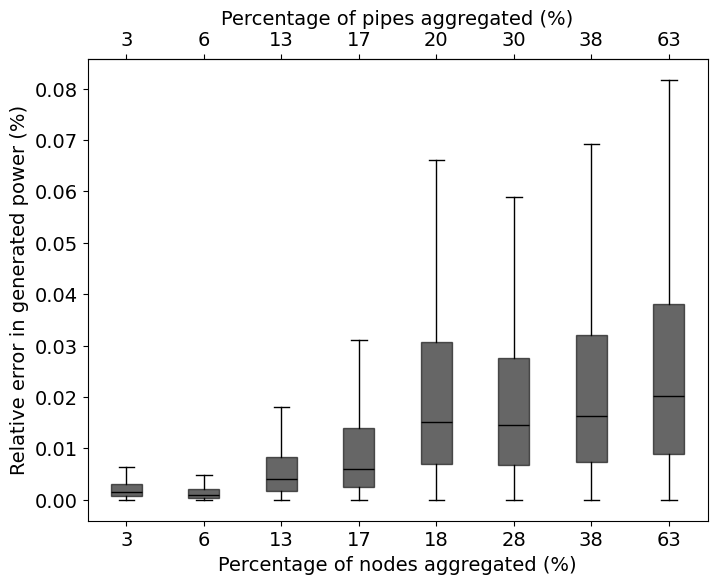

In [102]:
# Figure

fig, ax = plt.subplots(figsize=(8,6))

ax2 = ax.secondary_xaxis('top')
x_axis = []
x2_axis = []
position = 0
for key, row in df_.iterrows():
    if key == 'c':
        continue
    x_axis.append(int(np.round(row['clustered_nodes_percentage'])))
    x2_axis.append(int(np.round(row['clustered_pipes_percentage'])))
    ax.boxplot(row['1st_scenario_pw_source'], positions=[position], patch_artist=True,
                        widths=0.4,
                        showfliers=False,
                        boxprops={'color':'black', 'facecolor':'black', 'alpha':0.6},
                        flierprops={'color': 'black'},
                        capprops={'color': 'black'},
                        whiskerprops={'color': 'black'},
                        medianprops={'color': 'black'})

    position += 1

# ax2.cla()
ax2.set_xlabel('Percentage of pipes aggregated (%)', fontdict={'color': 'black', 'size': 14})
ax2.tick_params(axis='x', colors='black', labelsize=14)
ax2.set_xticks(range(position))
ax2.set_xticklabels(x2_axis)
set_my_layout(ax=ax, xlabel='Percentage of nodes aggregated (%)', ylabel='Relative error in generated power (%)', 
              set_legend=False,
              legend_loc=[1.01,0.01])
ax.set_xticklabels(x_axis) 
plt.savefig(os.path.join('.', 'ARTICLE_images_plots','Distribution_errors_hybrids_power_generated_rnn.svg'))
plt.show()

Here we assess the reduction of simulation time (s) per time step. The effective simulation time is given by the physical simulation (full network and reduced network) with the prediction times. 

The reader may notice that the inference times of ML models differ from than present in the paper. Indeed, our experiments have shown slightly different inference times of the ML models from python execution and julia execution (in PyCall [https://github.com/JuliaPy/PyCall.jl]) environments. Several executions have been run and average times are considered. CPU times depend on local computing powers and results reported below have been achieved on our local computer. They may differ from other executions setups (computation power available, CPU current usage, memory usage, etc.). However, they give indications of the expected trends of execution times decreases.

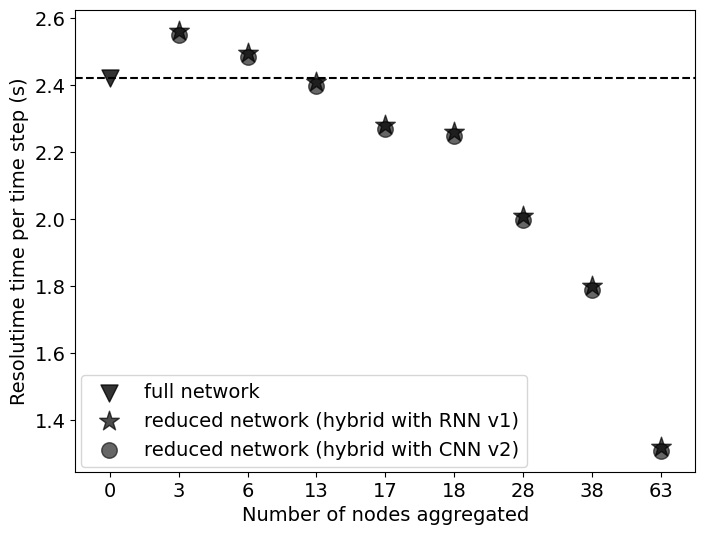

In [247]:
rnn_mean_inference_time = 0.01 # second # from Julia call (different from python 20 ms about)
cnn_mean_inference_time = 0.0098 # second # from Julia call (different from python 18 ms about) # about 2 ms of differences

resolution_times_from_julia = {
   'a': 1.963,
   'b': 1.895,
   'd': 1.81,
   'e': 1.68,
   'f': 1.20,
   'm': 1.66,
   'g_manual_1': 1.41,
   'f_manual_1': 0.72,
}

resolution_time_original = np.mean([2.38, 2.2, 2.685])

x_axis = []
x2_axis = []
y_axis = []
y_axis_cnn = []
for key, row in df_.iterrows():
   if key == 'c': # We pass c as it has the same number of nodes as d
      continue
   y_axis.append(resolution_times_from_julia[key] + rnn_mean_inference_time*60)
   y_axis_cnn.append(resolution_times_from_julia[key] + cnn_mean_inference_time*60)
   
   x_axis.append(int(np.round(df_.loc[key]['clustered_nodes_percentage'])))
   x2_axis.append(int(np.round(df_.loc[key]['clustered_pipes_percentage'])))
   
poly_fit = np.polyfit(x_axis, y_axis, 1)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter([0], [resolution_time_original], marker='v', color='black', s=150, label='full network', alpha=0.8)
ax.scatter(range(1,len(y_axis)+1), y_axis, alpha=0.7, s=220, marker='*', label='reduced network (hybrid with RNN v1)', c='black')
ax.scatter(range(1,len(y_axis)+1), y_axis_cnn, alpha=0.6, s=500, marker='.', label='reduced network (hybrid with CNN v2)', c='black')
ax.axhline(y=resolution_time_original, color='black', linestyle='--')
axs = ax.get_xticks()

set_my_layout(ax=ax, xlabel='Number of nodes aggregated', ylabel='Resolutime time per time step (s)',
              set_legend=True)

ax.legend(['full network', 'reduced network (hybrid with RNN v1)', 'reduced network (hybrid with CNN v2)'], prop={'size': 14},
          loc=[0.01,0.01])

ax.set_xticks(range(len(ax.get_xticks())))
ax.set_xlim([-0.5,8.5])
x_ = [0]
x_.extend(x_axis)
x_.append(0)
x_.append(0)
ax.set_xticklabels(x_)

plt.savefig(os.path.join('.', 'ARTICLE_images_plots', 'resolution_time_reduction.svg'))
plt.show()